In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from pathlib import Path
import numpy as np
from sympy import isprime
vectorized_isprime = np.vectorize(isprime)


# Automatically find the project root (assumes "src" is in the project)
current_file = Path(__file__).resolve() if '__file__' in locals() else Path.cwd()
project_root = current_file
while not (project_root / "src").exists() and project_root != project_root.parent:
    project_root = project_root.parent

# Ensure we found the correct project root
if not (project_root / "src").exists():
    raise FileNotFoundError("Could not find project root containing 'src' directory.")

# Set the working directory to the project root
os.chdir(project_root)



from src.evaluation.benchmark import run_full_benchmark, combine_jsons
from src.compression.utils_ND import *

/Users/maxge/miniconda3/envs/QEL/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [29]:
def calc_mean_std(dict, num_common_points, key = "compressionratio_list_disk"):
    ssims = np.array(dict["ssim_list"])
    comps = np.array(dict[key])
    shapes = np.array(dict["shapes"])
    max_common_fac = np.min(1/comps[:,-1])
    min_common_fac = np.max(1/comps[:,0])
    common_comp_facs = np.linspace(min_common_fac, max_common_fac, num_common_points)
    interpolated_ssim = []
    for x, y, s in zip(1/comps, ssims, shapes):
        if np.all(vectorized_isprime(s)==False):
            interp_func = interp1d(x, y, kind="linear", bounds_error=False)
            interpolated_ssim.append(interp_func(common_comp_facs))
    return np.mean(interpolated_ssim, axis = 0), np.std(interpolated_ssim, axis = 0), np.array(common_comp_facs)

In [42]:
with open("src/evaluation/results/MRI_slice_0_to_13_100_steps_to_03.json", "r") as f:
    results_Slice = json.load(f)

with open("src/evaluation/results/MRI_0_to_10_100_steps_to_01.json", "r") as f:
    results_MRI = json.load(f)
with open("src/evaluation/results/fMRI_0_to_5_100steps_to_01.json", "r") as f:
    results_fMRI = json.load(f)

In [31]:
print("Keys of the dictionary:")
print(results_MRI.keys())

Keys of the dictionary:
dict_keys(['Datatype', 'files', 'bitsize_list', 'shapes', 'cutoff_list', 'ssim_list', 'compressionratio_list', 'bonddim_list', 'plain_disk_size', 'gzip_disk_size', 'compressionratio_list_disk'])


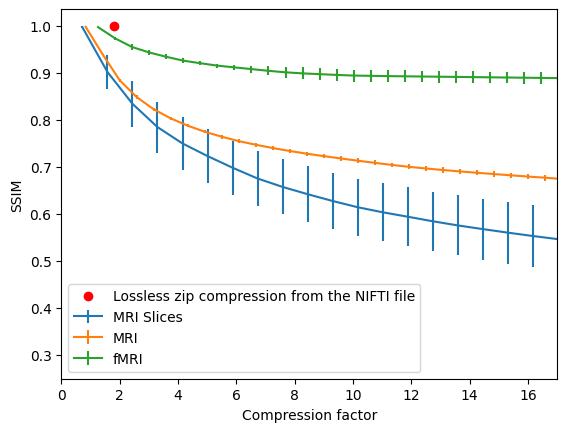

In [75]:
"""slice_mean, slice_std, slice_comp_facs = calc_mean_std(results_Slice, num_common_points=100, key="compressionratio_list")
MRI_mean, MRI_std, MRI_comp_facs = calc_mean_std(results_MRI, num_common_points=100, key="compressionratio_list")
fMRI_mean, fMRI_std, fMRI_comp_facs = calc_mean_std(results_fMRI, num_common_points=1000, key="compressionratio_list")
plt.errorbar(slice_comp_facs, slice_mean, yerr = slice_std, label = "MRI Slice")
plt.errorbar(MRI_comp_facs, MRI_mean, yerr = MRI_std, label = "MRI")
plt.errorbar(fMRI_comp_facs, fMRI_mean, yerr = fMRI_std, label = "fMRI")"""
slice_mean, slice_std, slice_comp_facs = calc_mean_std(results_Slice, num_common_points=120)
MRI_mean, MRI_std, MRI_comp_facs = calc_mean_std(results_MRI, num_common_points=30)
fMRI_mean, fMRI_std, fMRI_comp_facs = calc_mean_std(results_fMRI, num_common_points=1000)
plt.errorbar(slice_comp_facs, slice_mean, yerr = slice_std, label = "MRI Slices")
plt.errorbar(MRI_comp_facs, MRI_mean, yerr = MRI_std, label = "MRI")
plt.errorbar(fMRI_comp_facs, fMRI_mean, yerr = fMRI_std, label = "fMRI")
plt.plot(1.8,1,"ro",  label = "Lossless zip compression from the NIFTI file")
plt.xlim(0, 17)
plt.ylabel("SSIM")
plt.xlabel("Compression factor")
plt.legend()

In [28]:
slice_mean, slice_std, slice_comp_facs = calc_mean_std(results_Slice, num_common_points=100)
MRI_mean, MRI_std, MRI_comp_facs = calc_mean_std(results_MRI, num_common_points=100)
fMRI_mean, fMRI_std, fMRI_comp_facs = calc_mean_std(results_fMRI, num_common_points=1000)
plt.errorbar(slice_comp_facs, slice_mean, yerr = slice_std, label = "MRI Slice")
plt.errorbar(MRI_comp_facs, MRI_mean, yerr = MRI_std, label = "MRI")
plt.errorbar(fMRI_comp_facs, fMRI_mean, yerr = fMRI_std, label = "fMRI")
plt.xlim(0, 2)
plt.legend()

KeyError: 'shape_list'

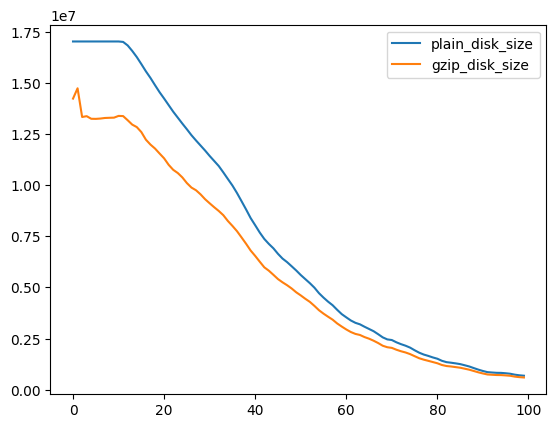

In [50]:
plt.plot(results_MRI["plain_disk_size"][i],label = "plain_disk_size")
plt.plot(results_MRI["gzip_disk_size"][i],label = "gzip_disk_size")
plt.legend()


In [82]:
combine_jsons("fMRI_0_to_5_100steps_to_01.json", "fMRI_5_to_15_100_steps_to_01.json", "fMRI_0_to_15_100_steps_to_01.json")

Combined JSON created successfully!


In [64]:
import nibabel as nib
mri_file = '/Users/maxge/Documents/Studium/München/02_SS 2024/QEL/Block encoding generalization/img-compression-mps/Data/MRI Dataset/sub-05_T1w.nii.gz'
img = nib.load(mri_file)
img_data = img.get_fdata()

In [65]:
img_int = scale_to_dtype(img_data, np.uint16)

In [66]:
import io, gzip

In [67]:
array_bytes = img_int.tobytes()
buffer = io.BytesIO()

with gzip.GzipFile(fileobj=buffer, mode='wb') as gz_file:
    gz_file.write(array_bytes)
compressed_data = buffer.getvalue()
compressed_size = len(compressed_data)

In [68]:
compressed_size

6574081

In [69]:
1/(compressed_size/len(array_bytes))

1.7943922504149248

In [17]:
from src.compression.mps_ND import NDMPS

In [18]:
mps = NDMPS.from_tensor(img_data, norm = False, mode="DCT")

/Users/maxge/Documents/Studium/München/02_SS 2024/QEL/Block encoding generalization/img-compression-mps/src/compression/utils_ND.py:82: RuntimeWarning: invalid value encountered in cast
  prod_block_sizes[0] = prod_block_sizes[0] * 1e100


In [19]:
mps.get_bytesize_on_disk()

46398528